In [76]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from lxml import etree as ET
import cv2 as cv
from shutil import copy
import os

for files in os.listdir('../input/face-mask-detection'):
    print(files)

annotations
images


In [77]:
def get_objects(file_path):
    
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    var_list = []

    for obj in root.iter(['name','xmin','ymin','xmax','ymax']):
        var_list.append(obj.text)
    
    return var_list
        

In [78]:
xml_path = '../input/face-mask-detection/annotations'
xml_files = sorted(os.listdir(xml_path))

objects = []

for file in xml_files:
    path = xml_path + '/' + file
    objects.append(get_objects(path))

print("Objects of first XML File :\n")
print(objects[0])

Objects of first XML File :

['without_mask', '79', '105', '109', '142', 'with_mask', '185', '100', '226', '144', 'without_mask', '325', '90', '360', '141']


In [79]:
root_file = '/kaggle/working/images'
with_mask = '/kaggle/working/images/with_mask'
without_mask = '/kaggle/working/images/without_mask'
mask_weared_incorrect = '/kaggle/working/images/mask_weared_incorrect'


try:
    os.mkdir(root_file)
    
except FileExistsError:
    print('Directory already Exists')
    
try:
    os.mkdir(with_mask)
    
except FileExistsError:
    print('Directory already Exists')

try:
    os.mkdir(without_mask)
    
except FileExistsError:
    print('Directory already Exists')
    
try:
    os.mkdir(mask_weared_incorrect)
    
except FileExistsError:
    print('Directory already Exists')


Directory already Exists
Directory already Exists
Directory already Exists
Directory already Exists


In [80]:
print(objects[0])

['without_mask', '79', '105', '109', '142', 'with_mask', '185', '100', '226', '144', 'without_mask', '325', '90', '360', '141']


In [81]:
def crop_and_copy_images(img_path,objects):
    
    root_path = './images'
    img_dir_path = '../input/face-mask-detection/images'
    
    cnt =0 
    
    for i in range(len(img_path)):
        image_file_path = img_dir_path + '/' + img_path[i]
        img = cv.imread(image_file_path)
        img = cv.cvtColor(img,cv.COLOR_RGB2BGR)
        
        for j in range(len(objects[i])//5):
            
            category = objects[i][j*5]
                
            x1 = int(objects[i][j*5+1])
            y1 = int(objects[i][j*5+2])
            x2 = int(objects[i][j*5+3])
            y2 = int(objects[i][j*5+4])
            
            crop = img[y1:y2,x1:x2]
            cnt+=1
            path = os.path.join(root_path,category,'img'+str(cnt)+'.png')
            cv.imwrite(path,crop)

In [82]:
img_dir_path = '../input/face-mask-detection/images'
img_file_path = sorted(os.listdir(img_dir_path))

crop_and_copy_images(img_file_path,objects)

In [83]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten

In [94]:
datagen = ImageDataGenerator(rescale=1/255,
                             brightness_range = [0.5,1.0],
                             zoom_range  = 0.1,
                             horizontal_flip = True,
                             validation_split=0.15,
                             shear_range=0.05
                            )

train_gen = datagen.flow_from_directory(
                                    './images',
                                    target_size=(128,128),
                                    subset ='training'
    
)

val_gen = datagen.flow_from_directory(
    './images',
    target_size=(128,128),
    subset ='validation'
    
)

Found 3463 images belonging to 3 classes.
Found 609 images belonging to 3 classes.


In [95]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 4
)

In [88]:
model = keras.Sequential([Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),
                          Conv2D(32,(3,3),activation='relu'),
                          MaxPooling2D(2,2),
                          Conv2D(64,(3,3),activation='relu'),
                          Conv2D(64,(3,3),activation='relu'),
                          Conv2D(64,(5,5),padding='same',activation='relu'),
                          MaxPooling2D(2,2),
                          Conv2D(128,(3,3),activation='relu'),
                          Conv2D(128,(5,5),padding='same',activation='relu'),
                          MaxPooling2D(2,2),
                          Conv2D(256,(5,5),activation='relu'),
                          Dropout(0.4),
                          Flatten(),
                          Dense(256,activation='relu'),
                          Dense(3,activation='softmax')
                         ])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

history= model.fit(train_gen,validation_data=val_gen,epochs=10,callbacks=[es])

Epoch 1/10
115/115 [==============================] - 23s 199ms/step - loss: 0.7716 - accuracy: 0.7059 - val_loss: 0.2703 - val_accuracy: 0.9187
Epoch 2/10
115/115 [==============================] - 22s 192ms/step - loss: 0.2505 - accuracy: 0.9271 - val_loss: 0.2569 - val_accuracy: 0.8966
Epoch 3/10
115/115 [==============================] - 21s 186ms/step - loss: 0.1931 - accuracy: 0.9433 - val_loss: 0.2808 - val_accuracy: 0.8892
Epoch 4/10
115/115 [==============================] - 22s 193ms/step - loss: 0.1978 - accuracy: 0.9371 - val_loss: 0.2371 - val_accuracy: 0.9089


Text(0.5, 1.0, 'Loss vs Epochs')

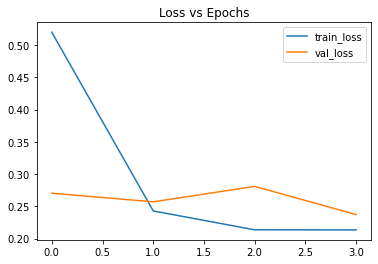

In [89]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss,label = 'train_loss')
plt.plot(val_loss,label = 'val_loss')
plt.legend()
plt.title('Loss vs Epochs')

Text(0.5, 1.0, 'Accuracy vs Epochs')

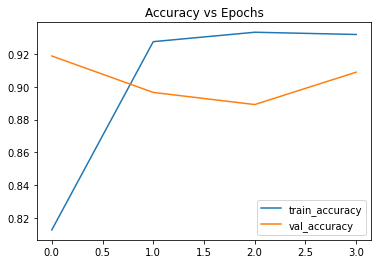

In [90]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_acc,label = 'train_accuracy')
plt.plot(val_acc,label = 'val_accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

In [91]:
model.save('mask_detection.h5')

In [92]:
!pip install mtcnn
from mtcnn.mtcnn import MTCNN

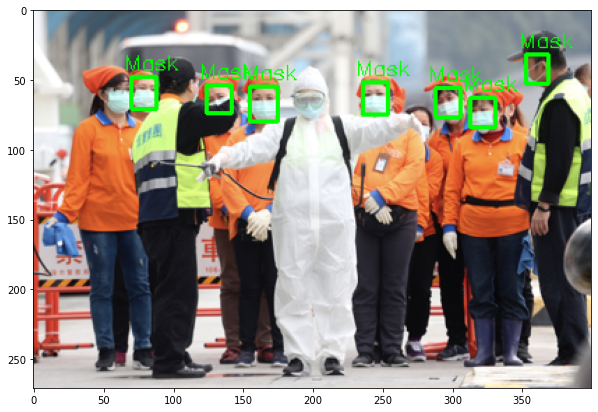

In [93]:
detector = MTCNN()

img = cv.imread('../input/face-mask-detection/images/maksssksksss3.png')
img = cv.cvtColor(img,cv.COLOR_RGB2BGR)

faces = detector.detect_faces(img)

for face in faces:
    
    x,y,w,h = face['box']
    
    crop = img[y:y+h,x:x+w]
    crop = cv.resize(crop,(128,128))
    crop = np.reshape(crop,[1,128,128,3])/255.0
    yhat = model.predict_classes(crop)

    if yhat ==1 or yhat==0:
        color = (0,255,0)
        label ='Mask'

    elif yhat==2:
        color = (0,0,255)
        label = 'No Mask'
        
    
    cv.rectangle(img,(x,y),(x+w,y+h),color,2)
    cv.putText(img,label,(x-5,y-5),cv.FONT_HERSHEY_SIMPLEX,0.5,color,1)

plt.figure(figsize=(10,10))
plt.imshow(img)